<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/MLP_pytorch_dataset_dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch を用いた MLP の実装
PyTorch にはミニバッチ学習を効率的に実装するため，Dataset と Dataloader を使用する実装がある。

## ライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

## データセットの定義とその利用

In [ ]:
# カスタムDatasetクラスの定義
class DigitsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# データの準備: 手書き数字データセット MNIST を用いる
def prepare_data(device='cpu'):
    # 手書き数字データセットの読み込み
    digits = load_digits()
    X, y = digits.data, digits.target

    # データの標準化
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # カスタムDatasetを作成
    dataset = DigitsDataset(X, y)

    # 訓練用とテスト用に分割 (8:2の比率)
    n_train = int(0.8 * len(dataset))
    n_test = len(dataset) - n_train
    train_dataset, test_dataset = random_split(dataset, [n_train, n_test])

    return train_dataset, test_dataset

## モデルの定義

In [ ]:
# MLPモデルの定義
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32,  16),
            nn.ReLU(),
            nn.Linear(16, output_size))

    def forward(self, x):
        return self.network(x)

### モデルの学習

In [ ]:
# モデルを学習するための関数
def train_model(model, train_loader, test_loader, device, epochs=100):
    # 損失関数とオプティマイザー
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 学習履歴を保存
    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        n_batches = 0

        # DataLoaderを使用したミニバッチ学習
        for batch_X, batch_y in train_loader:
            # データをデバイスに移動
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝播
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # 逆伝播
            loss.backward()
            optimizer.step()

            # 損失の累積
            epoch_loss += loss.item()
            n_batches += 1

        # エポックごとの平均損失を記録
        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)

        # テストデータでの精度評価
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                # データをデバイスに移動
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                # 予測
                test_outputs = model(batch_X)
                # 確率最大のクラスを取り出す
                _, predicted = torch.max(test_outputs.data, 1)
                # 正解数の累積
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        # 正解率を求める
        accuracy = correct / total
        test_accuracies.append(accuracy)

        # 進捗表示
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    return train_losses, test_accuracies

In [ ]:
# 最終的な性能評価を行う関数
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:

# メイン実行部分
if __name__ == "__main__":
    # デバイス設定
    # GPU が利用可能場合，GPU を利用する
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用デバイス: {device}")

    # データの準備
    print("データを準備中...")
    train_dataset, test_dataset = prepare_data(device)
    print(f"訓練データ: {len(train_dataset)}サンプル, テストデータ: {len(test_dataset)}サンプル")

    # DataLoaderの作成
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # モデルの作成
    input_size = 64  # load_digitsの特徴量数は64
    output_size = 10  # クラス数

    model = MLP(input_size, output_size)
    model = model.to(device)
    print(f"\nモデル構造:\n{model}")

    # モデルの学習
    print("\nモデルを学習中...")
    train_losses, test_accuracies = train_model(
        model, train_loader, test_loader, device,
        epochs=200
    )

    # 最終的な性能評価
    train_accuracy = evaluate_model(model, train_loader, device)
    test_accuracy = evaluate_model(model, test_loader, device)

    print(f"\n最終結果:")
    print(f"訓練データに対する正解率: {train_accuracy:.4f}")
    print(f"テストデータに対する正解率: {test_accuracy:.4f}")

使用デバイス: cpu
データを準備中...
訓練データ: 1437サンプル, テストデータ: 360サンプル

モデル構造:
MLP(
  (network): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)

モデルを学習中...
Epoch [20/200], Loss: 1.3120, Test Accuracy: 0.5611
Epoch [40/200], Loss: 0.6034, Test Accuracy: 0.8417
Epoch [60/200], Loss: 0.2968, Test Accuracy: 0.9167
Epoch [80/200], Loss: 0.1694, Test Accuracy: 0.9278
Epoch [100/200], Loss: 0.1106, Test Accuracy: 0.9583
Epoch [120/200], Loss: 0.0769, Test Accuracy: 0.9694
Epoch [140/200], Loss: 0.0549, Test Accuracy: 0.9722
Epoch [160/200], Loss: 0.0398, Test Accuracy: 0.9722
Epoch [180/200], Loss: 0.0290, Test Accuracy: 0.9722
Epoch [200/200], Loss: 0.0210, Test Accuracy: 0.9722

最終結果:
訓練データに対する正解率: 0.9986
テストデータに対する正解率: 0.9722


## 学習履歴の可視化

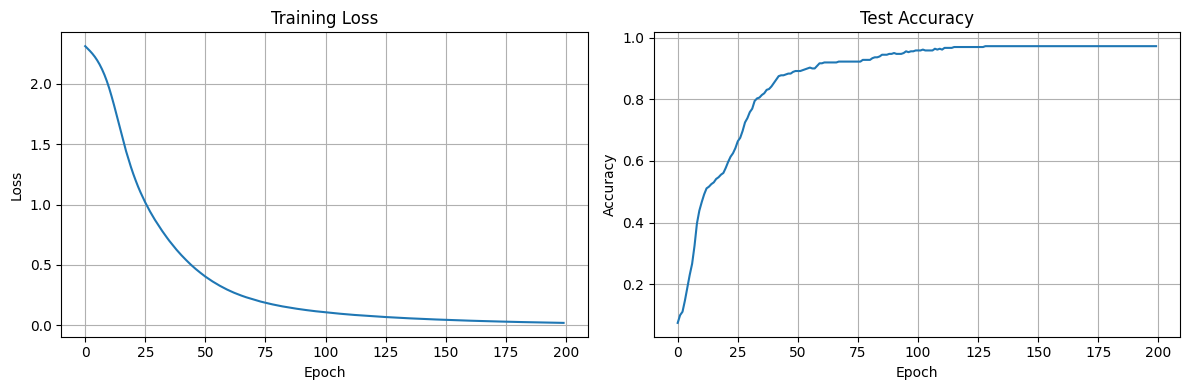

In [ ]:
# 可視化関数
def plot_training_history(train_losses, test_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 損失の推移
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # テスト精度の推移
    ax2.plot(test_accuracies)
    ax2.set_title('Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 学習履歴の可視化
plot_training_history(train_losses, test_accuracies)